# 프로젝트 : 더 멋진 번역기 만들기
---
- 한국어 문장 입력으로 부터 영어로 번역된 문장을 출력하는 번역기를 만들어보자. 

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)에서 제공하는 데이터셋 활용

In [2]:
#- 나눔글꼴 설치
! sudo apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20180306-3).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfcitx-utils0
  libfontembed1 libgnome-panel0 libgs9 libgs9-common libido3-0.1-0 libijs-0.35
  libindica

In [3]:
#- SentencePiece 설치

! pip install sentencepiece

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


In [5]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import sentencepiece as spm

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

from tqdm import tqdm
from tqdm import tqdm_notebook
import random


print(tf.__version__)

2.6.0


In [6]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [7]:
data_dir

'/aiffel/aiffel/transformer/data'

In [8]:
kor_path

'/aiffel/aiffel/transformer/data/korean-english-park.train.ko'

In [9]:
eng_path

'/aiffel/aiffel/transformer/data/korean-english-park.train.en'

In [10]:
with open(kor_path, "r") as f: kor = f.read().splitlines()
with open(eng_path, "r") as f: eng = f.read().splitlines()
print("Data Size:({},{})".format(len(kor), len(eng)))
print("Example:")

cnt = 0
for ko, en in zip(kor, eng):
    print(f">>\n한국어 : {ko}\n영어 : {en}\n")
    cnt += 1
    if cnt == 5:
        break

Data Size:(94123,94123)
Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어 : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어 : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

# 2. 데이터 정제 및 토큰화 
### 1) 중복데이터 제거
- set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터 제거 
- 중복을 제거한 데이터를 cleaned_corpus 에 저장

In [11]:
# 데이터 정제 및 토큰화
def clean_corpus(kor, eng):
    assert len(kor) == len(eng)
    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

In [12]:
cleaned_corpus = clean_corpus(kor, eng)
len(cleaned_corpus)

78968

### 2) 정제함수 정의

- 모든 입력을 소문자로 변환
- 알파벳, 문장부호, 한글만 남기고 모두 제거
- 문장부호 양옆에 공백을 추가
- 문장 앞뒤의 불필요한 공백을 제거

In [13]:
def preprocess_sentence(sentence):
    sentence = sentence.lower() #- 소문자 변환
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence) #- 알파벳, 문장부호, 한글 이외는 제거
    sentence = re.sub(r'[" "]+', " ", sentence) #- 여러개의 공백은 하나의 공백으로 바꾸기
    sentence = sentence.strip() #- 양쪽 공백 제거
    return sentence

### 3) 토큰화
- 한글 말뭉치 `kor_corpus` 와 영문 말뭉치 `eng_corpus` 를 각각 분리한 후, 정제하여 토큰화 
- 토큰화에는 [SentencePiece](https://github.com/google/sentencepiece)를 사용 
    - `generate_tokenizer()` 함수를 정의하여 최종적으로 `ko_tokenizer`와 `en_tokenizer`를 얻는다. 
    - `en_tokenizer`에는 `set_encode_extra_options("bos:eos")` 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 한다.
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 한다.(기본 : 20,000)
    - 학습 후 저장된 model 파일을 `SentencePieceProcessor()` 클래스에 `Load()`한 후 반환
    - 특수 토큰의 인덱스를 아래와 동일하게 지정
        - `<PAD>` : 0 / `<BOS>` : 1 / `<EOS>` : 2 / `<UNK>` : 3
        
- [spm의 입력은 txt로 넣어야 한다.](https://lovit.github.io/nlp/2018/04/02/wpm/)

In [14]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, 
                       model_type='unigram', 
                       vocab_size=32000, 
                       lang="ko"): 
    
    input_file = f'{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))
        
    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)
    
    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s --model_prefix=%s --vocab_size=%s --character_coverage=%s --model_type=%s'
    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, character_coverage, model_type)
                      
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')
    
    return tokenizer

In [15]:
cleaned_corpus[1]

('삼성은 1999년에서 2002년 사이 PC와 휴대전화에 사용되는 반도체 가격을 다른 반도체 제조업체와 담합한 혐의를 받고 있다.',
 'Samsung was accused of conspiring with other chipmakers to fix the price of chips sold for use in PCs and mobile phones between 1999 and 2002.')

In [16]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 32000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0],pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, 'unigram', SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, 'unigram', TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_spm_input.txt --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --model_prefix=sentencepiece/tokenizer_ko_unigram32000 --vocab_size=32000 --character_coverage=1.0 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_spm_input.txt
  input_format: 
  model_prefix: sentencepiece/tokenizer_ko_unigram32000
  model_type: UNIGRAM
  vocab_size: 32000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  ha

True

quent sub strings...
unigram_model_trainer.cc(194) LOG(INFO) Initialized 123580 seed sentencepieces
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 78956
trainer_interface.cc(537) LOG(INFO) Done! 69642
unigram_model_trainer.cc(489) LOG(INFO) Using 69642 sentences for EM training
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=41593 obj=10.3115 num_tokens=127305 num_tokens/piece=3.06073
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=33057 obj=8.11421 num_tokens=127080 num_tokens/piece=3.84427
trainer_interface.cc(615) LOG(INFO) Saving model: sentencepiece/tokenizer_en_unigram32000.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: sentencepiece/tokenizer_en_unigram32000.vocab


In [17]:
ko_test_txts = ['세계기상기구는 “코로나19에 따른 경제 활동 둔화로 탄소 배출이 일시적으로 줄었지만, 대기 중 이산화탄소 농도에 뚜렷한 영향을 주지 못했다”고 설명했다.','기후변화 대응·적응에 필요한 재원 분담 과정에서 나타나는 선진국과 개발도상국의 이견도 오래 묵은 논쟁거리다.']
en_test_txts = ['Democrats, including President Biden, are lobbying for Senator Joe Manchin’s support, knowing he is a crucial swing vote on their domestic agenda.','The contest to fill a vacant State House seat in South Texas has exposed the vulnerabilities of a Democratic stronghold.']


In [18]:
def testSP(sp, txts):
    tokens_list = []
    for txt in txts:
        tokens = sp.encode_as_pieces(txt)
        #ids = sp.encode_as_ids(txt)
        tokens_list.append(tokens)
    return tokens_list

In [19]:
testSP(ko_tokenizer, ko_test_txts)

[['▁세계',
  '기',
  '상',
  '기구',
  '는',
  '▁',
  '“',
  '코',
  '로',
  '나',
  '19',
  '에',
  '▁따른',
  '▁경제',
  '▁활동',
  '▁둔화',
  '로',
  '▁탄소',
  '▁배출',
  '이',
  '▁일시적',
  '으로',
  '▁줄',
  '었지만',
  ',',
  '▁대기',
  '▁중',
  '▁이산화탄소',
  '▁농도',
  '에',
  '▁뚜렷',
  '한',
  '▁영향',
  '을',
  '▁주지',
  '▁못했다',
  '”',
  '고',
  '▁설명했다',
  '.'],
 ['▁기후변화',
  '▁대응',
  '·',
  '적',
  '응',
  '에',
  '▁필요한',
  '▁재원',
  '▁분담',
  '▁과정에서',
  '▁나타나',
  '는',
  '▁선진국',
  '과',
  '▁개발도상국',
  '의',
  '▁이견',
  '도',
  '▁오래',
  '▁묵',
  '은',
  '▁논쟁거리',
  '다',
  '.']]

In [20]:
testSP(en_tokenizer, en_test_txts)

[['<s>',
  '▁',
  'D',
  'em',
  'ocrats',
  ',',
  '▁including',
  '▁',
  'P',
  'res',
  'ident',
  '▁',
  'B',
  'iden',
  ',',
  '▁are',
  '▁lobby',
  'ing',
  '▁for',
  '▁',
  'S',
  'en',
  'ator',
  '▁',
  'J',
  'o',
  'e',
  '▁',
  'M',
  'an',
  'chi',
  'n',
  '’',
  's',
  '▁support',
  ',',
  '▁knowing',
  '▁he',
  '▁is',
  '▁a',
  '▁crucial',
  '▁swing',
  '▁vote',
  '▁on',
  '▁their',
  '▁domestic',
  '▁agenda',
  '.',
  '</s>'],
 ['<s>',
  '▁',
  'T',
  'he',
  '▁contest',
  '▁to',
  '▁fill',
  '▁a',
  '▁vacant',
  '▁',
  'S',
  'tate',
  '▁',
  'H',
  'ouse',
  '▁seat',
  '▁in',
  '▁',
  'S',
  'out',
  'h',
  '▁',
  'T',
  'ex',
  'as',
  '▁has',
  '▁exposed',
  '▁the',
  '▁vulnerabilities',
  '▁of',
  '▁a',
  '▁',
  'D',
  'e',
  'mo',
  'cratic',
  '▁stronghold',
  '.',
  '</s>']]

### 4) 데이터 선별
- 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축
- 이후 텐서 enc_train 과 dec_train 으로 변환

In [21]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50 :
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

# 3. 모델 설계


In [22]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)  
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions 
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        # 1. Attention Weights 값 구하기 -> attentions
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 2. Attention 값을 V에 곱하기 -> out
        out = tf.matmul(attentions, V)
        return out, attentions
    
    def split_heads(self, x):
        """
        Embedding된 입력을 head의 수로 분할하는 함수
        
        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x
    
    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
        
        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x
    
    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [24]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
        return out

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        #- Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        #- Position-Wise Feed Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        #- Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        #- Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        #- Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size,
                 pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        #- 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        #- 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        #- 6. Dropout 정의
        self.do = tf.keras.layers.Dropout(dropout)
        
        #- 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        #- 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        #- 5. Shared Weights
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        #- Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        #- Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        #- Step 3: Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        #- Step 4: Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [30]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# 4. 훈련
### 1) 모델 선언
- Layer를 가지는 Transformer 선언. (하이퍼파라미터는 자유롭게 조절)

In [31]:
transformer = Transformer(
    n_layers=4,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

### 2) Learning Rate Scheduler
- 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언합니다. 

In [32]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [33]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### 3) Loss 함수 정의
- Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4) train_step 함수 정의
- 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다. 

In [35]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 5) 학습 진행
- 매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 기록합니다. 

- 예문
    1. 오바마는 대통령이다.
    2. 시민들은 도시 속에 산다.
    3. 커피는 필요 없다.
    4. 일곱 명의 사망자가 발생했다.
    5. 투표는 시민의 권리이다.
    6. 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
    7. 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
    8. 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
    

In [36]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [37]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [38]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president barack obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: the dow is the first time.
Input: 커피는 필요 없다.
Predicted translation: we are going to be a very.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed in the town of the town of the deaths.
Input: 투표는 시민의 권리이다
Predicted translation: the new economy is the first time of the economy.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the two of the , and the united states, and the mainly the mainly during the country.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the economy is a new energy of the u.s. economy, and the u.s. economy.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: the international committee of the international committee, and the international committee of the international community in the international city of the international city.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a lot of time.
Input: 시민들은 도시 속에 산다.
Predicted translation: it s a lot of time.
Input: 커피는 필요 없다.
Predicted translation: coffee is coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the deaths.
Input: 투표는 시민의 권리이다
Predicted translation: voting is the first time in the voting of the voting rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the problem is a major issue of the problem of the animal, which is a critical of the world.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the energy institute of the current energy institute for the u.s.s.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park jin, who has been a few years ago, said park s international community is a very sensitive time.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president is the same.
Input: 시민들은 도시 속에 산다.
Predicted translation: city is the urban urban urban.
Input: 커피는 필요 없다.
Predicted translation: coffee has just a lot of coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the nine were killed sunday.
Input: 투표는 시민의 권리이다
Predicted translation: the voting rights is the right rights to be the right rights of rights rights rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the problem is the problem of the problem, the problem of the problem, and the cause of the problem.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the move is not a non binding resolution to the u.s. auto companies, and the fact that the current policies would be the first of the national tax system.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was the first time in years ago, and formerly known as the international pressure.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: city
Input: 커피는 필요 없다.
Predicted translation: it is not easy to need to watch.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed wednesday.
Input: 투표는 시민의 권리이다
Predicted translation: voting is the rights of voting rights rights groups.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking drinking is a very good time for the failure of the liver, the agency said.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: the obama administration has a history of u.s. auto industry, which has been used by the united states, which has been used for the world health organization for the administration.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, pak gil, said the international monetary fund who had been criticized for years ago.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: city s mayor s urbana.
Input: 커피는 필요 없다.
Predicted translation: don t need to be able to need to be able to catch coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed seven people and seven were hurt.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is the most civil rights abuse than the power of right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the whole system is known for the liver, liver and distress of the disease, which is similar to the liver.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: even more important by the green energy strategy, the u.s. administration has estimated . trillion since the collapse.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park was made several years ago when a growing number of international organizations including the international mo

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is quiet for urban.
Input: 커피는 필요 없다.
Predicted translation: no need to need.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported in the death of seven deaths.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is the most civil rights civil rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: drinking smoking is the largest conservative civic group, an conducted linked to the holy land, an estimated , people of the holy land, the land and the sun, the alcohol, and expert and the organization of the ruling.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: it s a green, which has been forced to study u.s. energy policies, has been found in the united states, which has forced to study the energy administration.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, who had

  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the kind of a.
Input: 시민들은 도시 속에 산다.
Predicted translation: city is its th century city.
Input: 커피는 필요 없다.
Predicted translation: not a needed to be short of the states need to be.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the rampage.
Input: 투표는 시민의 권리이다
Predicted translation: it is a citizen of right citizens.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the alcohol is the oldest, and the families of the , have been suffering by the kremlin of the cold and is suffering by the cold and a key part of the deal.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green, the washington times says, is the first washington anti missile crisis.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park s body was sentenced to more than a decade ago in a controlled world.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s
Input: 시민들은 도시 속에 산다.
Predicted translation: city
Input: 커피는 필요 없다.
Predicted translation: not a needed to be able to.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed when the plane.
Input: 투표는 시민의 권리이다
Predicted translation: is the citizen s most citizen.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking sun, which is suspected of involvement, will be linked to the disease caused by blood vessels, an empty train and what caused the disease line.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: either way, or for the auto makers, this is to grow by .
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: parked a couple of pro tibet children just two years ago


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the dead is a message of obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens travel there were a downtown street.
Input: 커피는 필요 없다.
Predicted translation: need to need to be a short summit needed to be needed.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed when .
Input: 투표는 시민의 권리이다
Predicted translation: the right to citizen you.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the normal day will be linked to the arrival of the alcohol giant, doctors and few minutes of public services, the state drug gangs.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: i ve got green, one republican iowa several to administration and bring the prosecution to report that rather than report.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, a several years ago, was ready to resume operations abroad.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s proudly cities.
Input: 커피는 필요 없다.
Predicted translation: don t need to be drinking.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed when .
Input: 투표는 시민의 권리이다
Predicted translation: right, it has a special voting rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the city is systematically commerce secretary for the holy synod, an particular train yesterday to form a particular tuning system.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: i ve always been a low cell phone that does not have to look after that s important for coal use, or satellite surveillance underground.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, confiscated international visitors from a global poverty stricken area.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is barack obama.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens
Input: 커피는 필요 없다.
Predicted translation: don t need to be.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed when seven marines.
Input: 투표는 시민의 권리이다
Predicted translation: right is the right of voting rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the choice of , was known for the new terms as behavior due to speculation that was suffering on the effects of the past year.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: it is over for some development, though, by the american people.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is on an international appearance at an international monetary policy, park opposes an international attention.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is.
Input: 시민들은 도시 속에 산다.
Predicted translation: city
Input: 커피는 필요 없다.
Predicted translation: don t need to be coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people were killed wednesday.
Input: 투표는 시민의 권리이다
Predicted translation: the voting is a great calling for its right to have rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: normal relations between the two nations were named after the bird, ride over the album of the organization.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green, has gone to indicted some in the united states, where coal oil is now working for the union.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park earth ring delivered a brief appearance in , a brief stand.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens.
Input: 커피는 필요 없다.
Predicted translation: don t need to be coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died thursday.
Input: 투표는 시민의 권리이다
Predicted translation: the vote is.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the problems are for the children s resume over the gets to have been raised by the sun, october , he said.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: green has officials said several other options, but that s administration has come up with light, like that s being used by the energy administration.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park also had a studied against the international ocean in .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the same.
Input: 시민들은 도시 속에 산다.
Predicted translation: city was peaceful. this peak.
Input: 커피는 필요 없다.
Predicted translation: don t need to be d cat.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in hospital.
Input: 투표는 시민의 권리이다
Predicted translation: right is the right of a voting rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the legislators is known as the side of a result of an average of unclear.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: he says the union is likely to split after that unidentified administration officials say whether or not the administration should use energy use their computers.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park in , started as an international percent concerned by more because he feared.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is also down.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens.
Input: 커피는 필요 없다.
Predicted translation: if not needed to need it.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven people escaped.
Input: 투표는 시민의 권리이다
Predicted translation: voting is a candidate to get its.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking sun, which is a police station for the may decision to been an verses of the buy, caused by the september experts, and apologized to the liver disease.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: it is more likely to although the american times, he said, with christmas won t lives.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, , cuts some of the international kidney gave under consideration in the situation .


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in texas.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens took city in the streets.
Input: 커피는 필요 없다.
Predicted translation: the coffee need to be short of need to be short of need to.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven deaths reported on thursday.
Input: 투표는 시민의 권리이다
Predicted translation: right is the right of right.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the choice of cities is the third biggest form of the bound to date known set for the cancer patients.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: it is unclear, but anchor says he has got between joe biden and obama  levels.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is years old, who is global like the international whaling organization, park opposed to a forum nearly two years ago.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is downing lights.
Input: 시민들은 도시 속에 산다.
Predicted translation: city
Input: 커피는 필요 없다.
Predicted translation: if not chun ever catch being returned to israel.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven victims were hurt.
Input: 투표는 시민의 권리이다
Predicted translation: it is the right of france.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the alcohol is between , supporters, an alcohol tax broke out in the deaths of students, an promised best part of the effects of the sun.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: he is like green, a former top joe biden gets to release four administration officials as less fuel.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is accused of injuries ahead in , eight years ago of roh s deadly commercial status.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is also the president.
Input: 시민들은 도시 속에 산다.
Predicted translation: city
Input: 커피는 필요 없다.
Predicted translation: need to need at some coffee.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people died in .
Input: 투표는 시민의 권리이다
Predicted translation: the right is a voting rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the choice between , students and , been involved in the dispute between the seoul and owner of the baby average hammerhead.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: it is more important to make official feel created by the american relations with energy conservation, which are used by bush administration officials to keep that down.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park, wearing several years ago, was shown by a political organization nearly increasing the status of t help.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is kind of thing.
Input: 시민들은 도시 속에 산다.
Predicted translation: city s mayor is animals in the city.
Input: 커피는 필요 없다.
Predicted translation: if not needed to wear dark as to catch protesters.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven people died when seven marines came to .
Input: 투표는 시민의 권리이다
Predicted translation: the right dog rights are for the right of voting rights.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the normal train bombings had been under wraps for the large end of the relationship.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: he is more war than percent after the american film, which has seen up to percent of those nearly years, according to the u.s. energy officials.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: former south korea star richard international poverty showed him nearly years ago.


  0%|          | 0/1182 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s former president.
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens.
Input: 커피는 필요 없다.
Predicted translation: need to be interview.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen people were killed in .
Input: 투표는 시민의 권리이다
Predicted translation: right is the right of a voting rights in the right of voting.
Input: 음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.
Predicted translation: the drinking oktoberfest between will include the offense of alcohol, drinking and close some suspect, drinking.
Input: 친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.
Predicted translation: he says administration policies for the use of force to resign tuesday, after coal indicated obama s use says it has his energy penalty forty years or for coal energy.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is also replaced by international park.
Input: 박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다.
Predicted translation: park is als

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


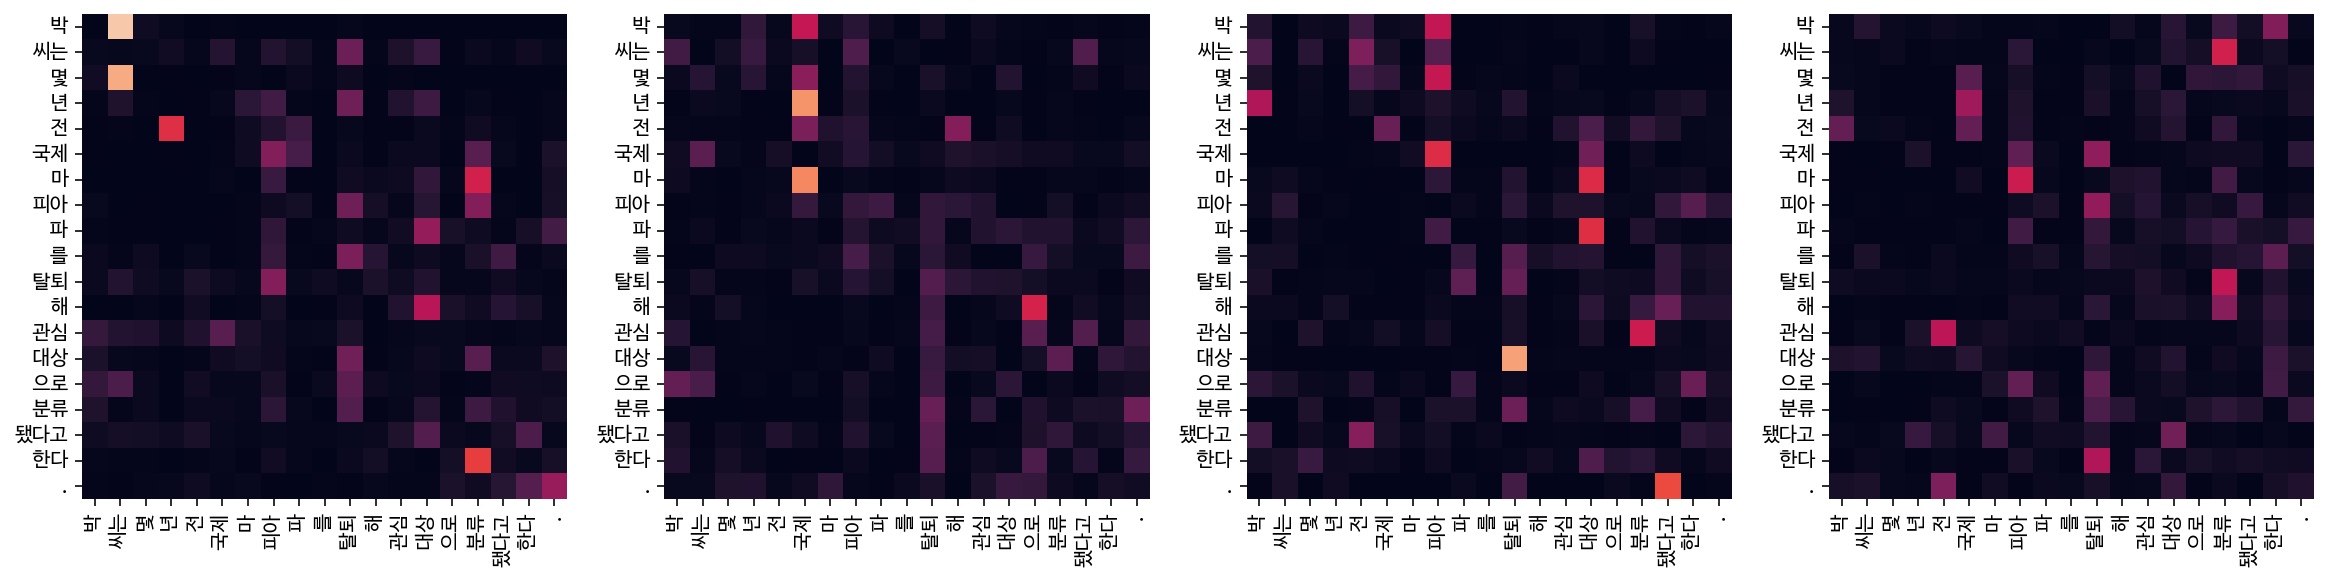

Encoder Layer 2


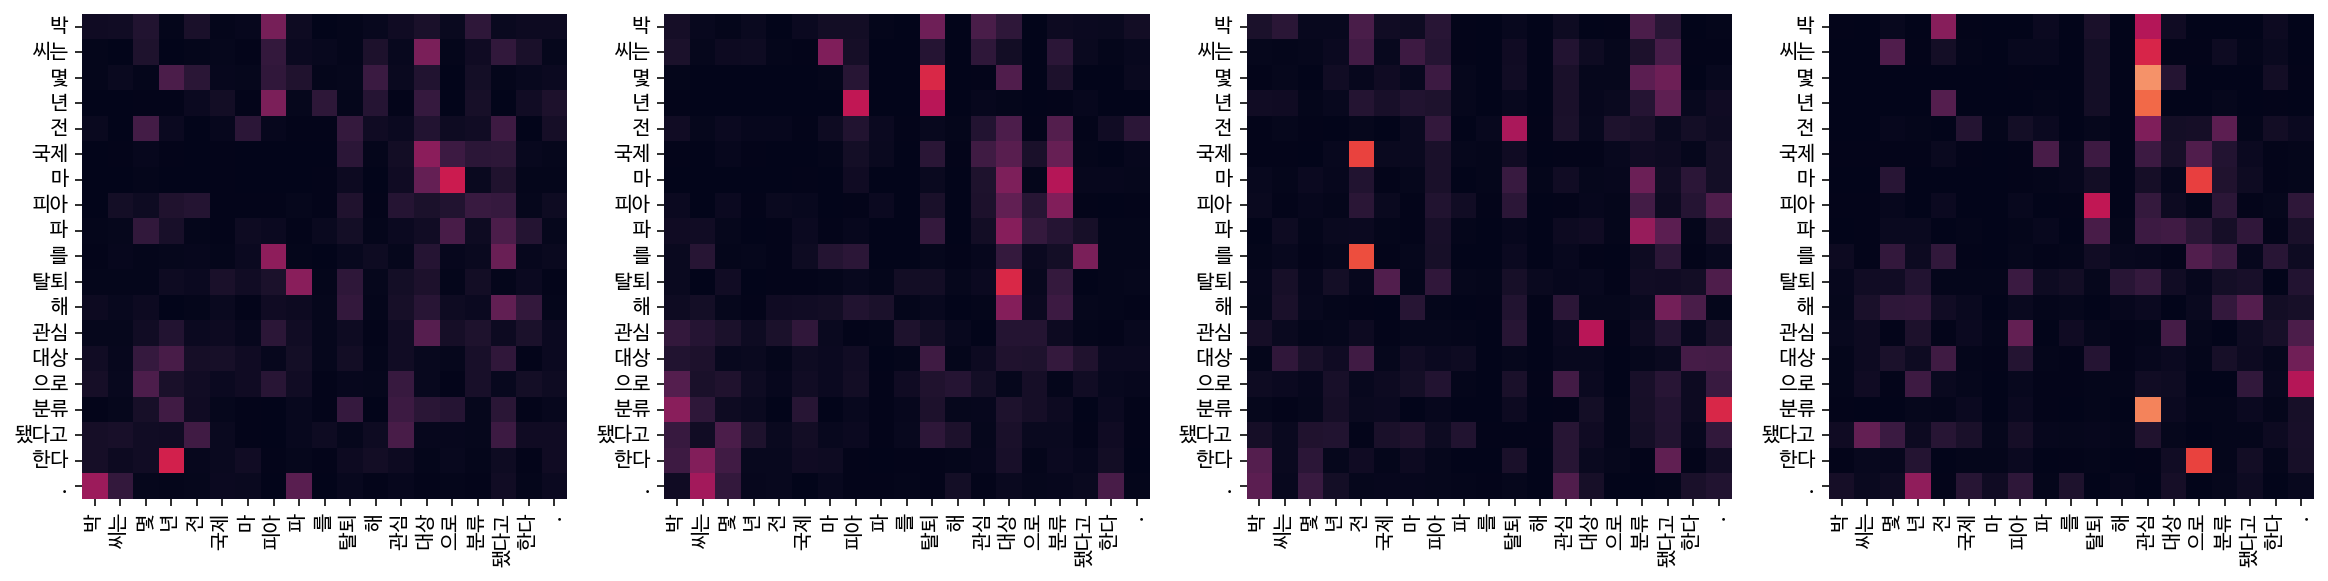

Decoder Self Layer 1


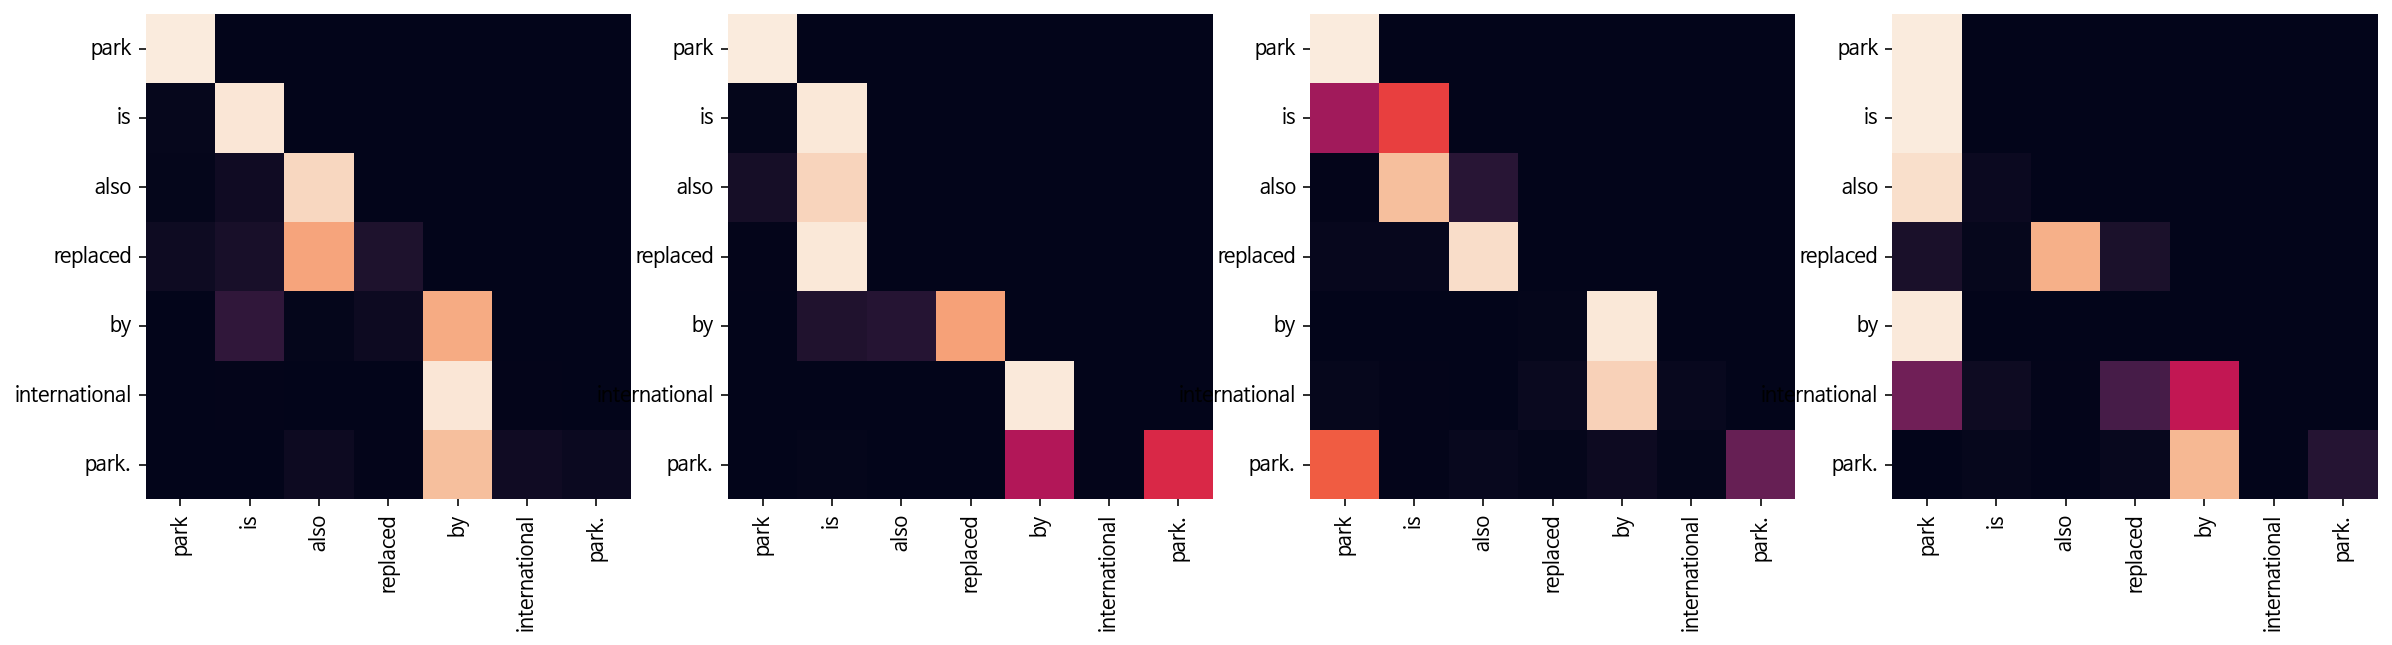

Decoder Src Layer 1


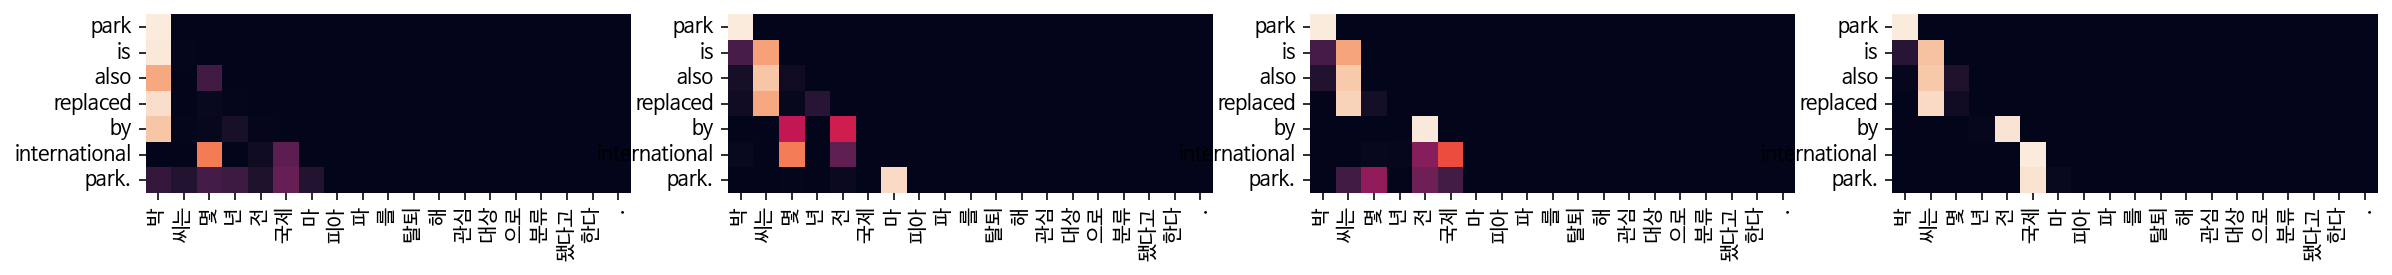

Decoder Self Layer 2


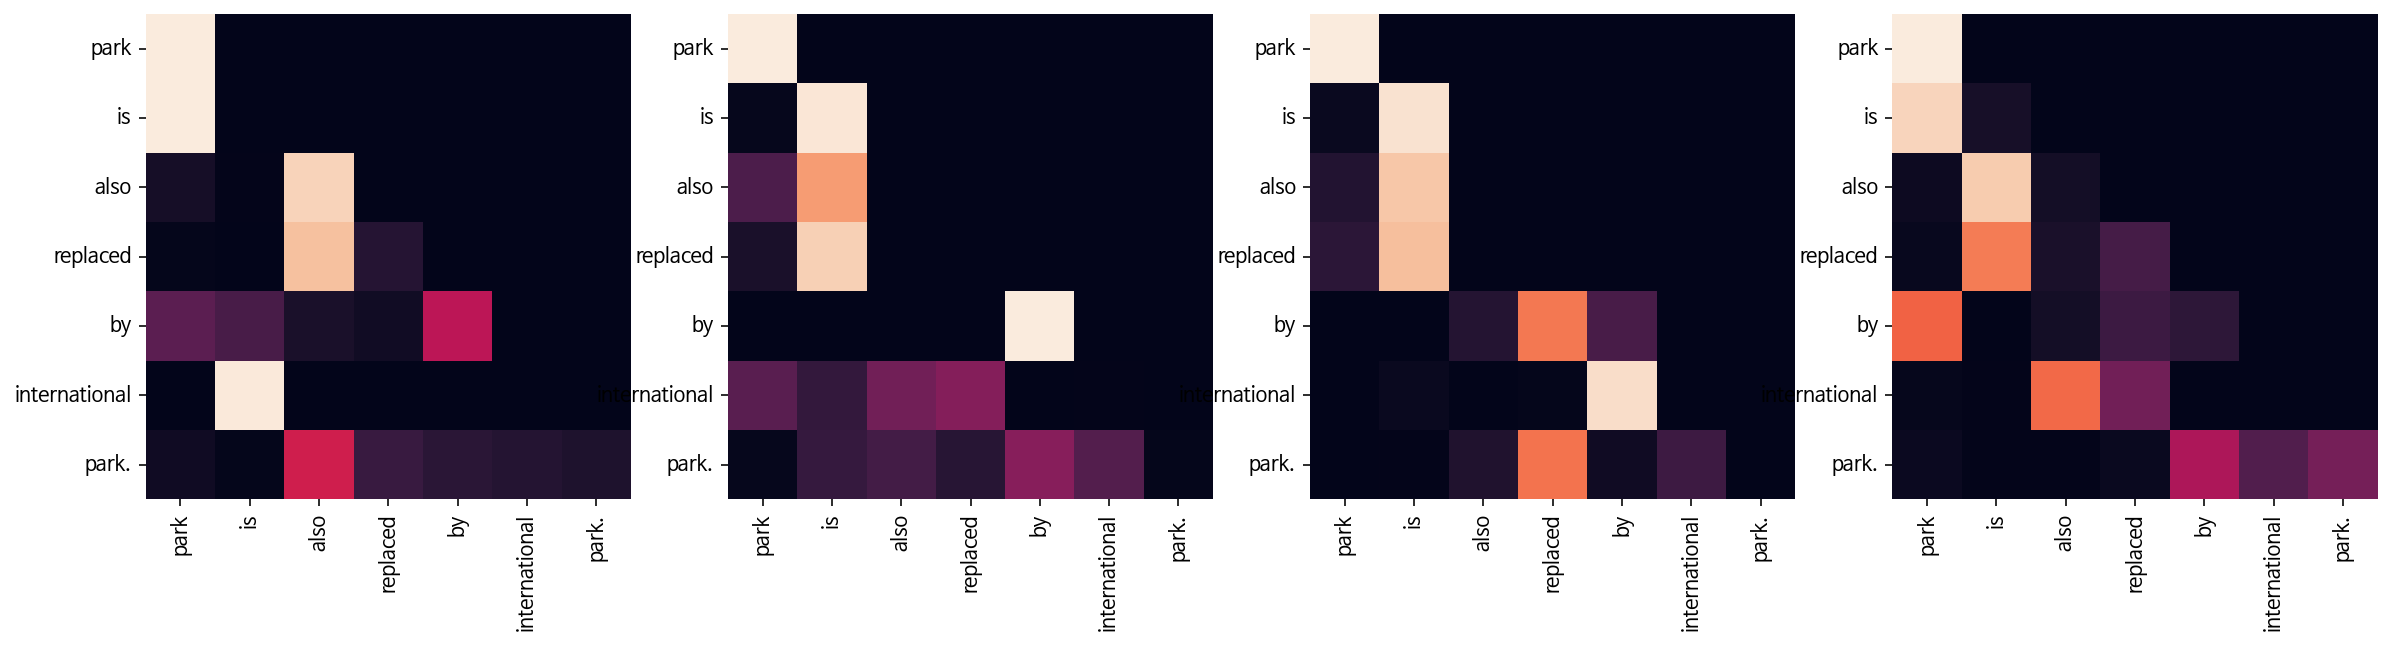

Decoder Src Layer 2


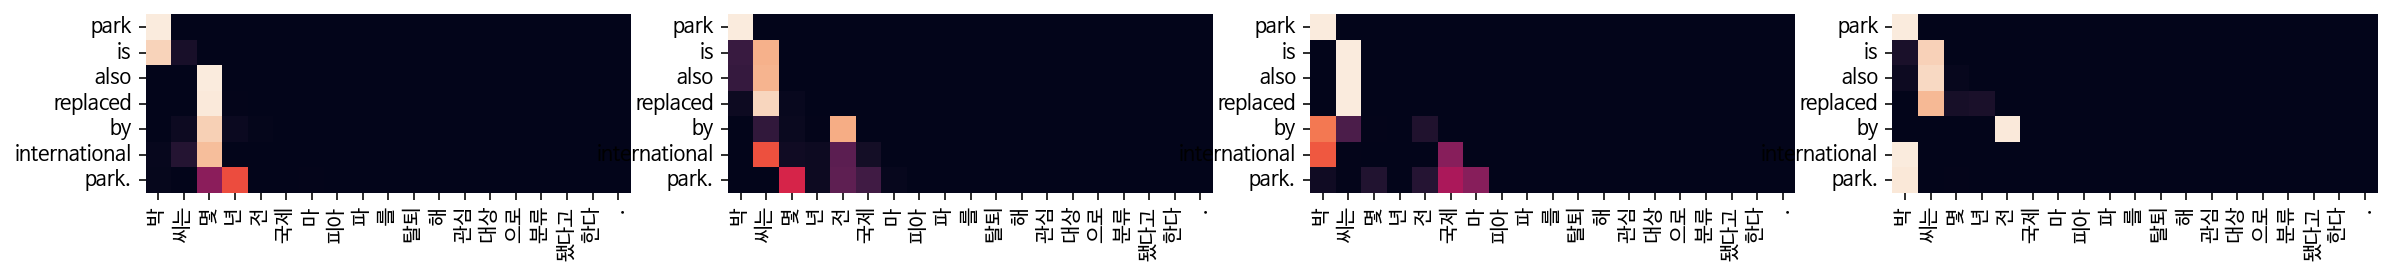

In [39]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다.",
            "투표는 시민의 권리이다",
            "음주는 만성간염, 간경변증, 간암의 대표적인 원인이다.",
            "친환경 에너지 정책을 펼쳐온 미국 조 바이든 행정부가 올 들어 석탄 사용량을 늘린 것으로 나타났다.",
            "박씨는 몇 년 전 국제마피아파를 탈퇴해 ‘관심 대상’으로 분류됐다고 한다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)
    
    if epoch == EPOCHS -1 : translate(example, transformer, ko_tokenizer, en_tokenizer, True)
        


## 회고

### 시도한 Hyperparameters
- n_layers: 2, 4, 6
- d_model: 512
- n_heads: 8
- d_ff: 2048
- dropout: 0.2, 0.3, 0.5
- epochs : 20, 10, 15

### Training Parameters
- Warmup Steps: 4000
- Batch Size: 64

### 최종 정리

- 2개의 층만 쌓은 Transformer의 결과는 한국어 문장을 영어 문장으로 완벽히 번역해내지는 못했지만, 문법적으로 왠만큼 잘 들어맞으며 P04에서 실습한 BahdanauAttention model(n_layers: 2, d_model: 512, Batch Size: 64, Epoch At: 10)에 비해 문맥에 어울리는 번역을 해내는 것을 확인할 수 있습니다.
- 논문에서 인코더와 디코더를 각각 6개를 사용하기 때문에, n_layers를 늘리면 성능 향상이 될 것으로 예상하여
- 실제로 n_layers : 2, 4, 6으로 변경하여 시도해 보았지만 n_layers : 2 > 4 > 6 순으로 좋게 나왔다.
- n_layers 층의 수량도 영향을 끼치지만 vocab_size, max_length, dropout 등에 따른 영향이 더 큰것 같다.
- epochs 수도 많이 할수록 성능이 더 하락하는 결과도 볼 수 있었다.
- transformer 이해도가 부족하여 프로젝트 수행도 어렵고 결과에 대한 분석을 하기도 어려웠다.